# Animating Complete NBA Games with Matplotlib and Pandas

In this notebook, we will explore pulling shot positional data from the NBA's undocumented API and then animating entire games with Matplotlib one shot at a time. 

## Jump to Results
Below is the video that is created at the very end of the tutorial. For those that are too lazy, here is the final creation.

In [1]:
from IPython.display import Video
Video('videos/nba_game_animation.mp4', width=800)

## Motivation: Game 7 of NBA finals - June 19, 2016
If you are unfamiliar with what is meant by 'shot positional data', let's first take a look at an example below of the game played between the Cleveland Cavaliers and the Golden State Warriors on June 19, 2016.

### All data is from nba.com
The NBA has a great website at [nba.com][1] and supplies most of the pertinent data on its [stats page][2].

### Select a specific game
Once you have navigated to the stats page, click on the **scores** section and then use the calendar to select the date June 19, 2016. Here is a [direct link][4]. You should see the image below:

![][3]

[1]: http://nba.com
[2]: http://stats.nba.com
[3]: images/june19.png
[4]: https://stats.nba.com/scores/06/19/2016

## Shot Positional Data
The NBA tracks almost every piece of data imaginable during the game. In this tutorial, we will look at the 'shot positional data', which consists of the following:

* The location of the shot on the court
* Whether the shot was made or missed
* The player attempting the shot
* The time remaining in the game

### Get the data
From the scores page above click on **Box Score**. You will get many traditional stats for both teams.

![][1]

[1]: images/box_score.png

### Notice the message for Shot Chart

There is a small message above the box score that all linked stats have a **Shot Chart**. To get the short chart for the Cleveland Cavaliers, click the number 82 in the **FGA** column. This is all the field goals attempted (shots) by them for the entire game. You will get the following image in a new page.

![][1]

[1]: images/shotchart.png

## Getting the short chart data in a Pandas DataFrame

This following section is created from a great blog post by [Greg Reda][1] on how to reverse engineer an API.

### No Web Scraping - Finding the internal API

Often times, we will have to scrape the raw HTML to get the data we want, but in this case, the data is fetched through an internal API that the NBA maintains. As far as I know, they do not show how it is publicly used. So, in order to get the data, we will have to take a peak into the requests being made as the page is loading.

### Using the developer tools

All browsers have tools for web developers. In Google Chrome we can find the developer tools by clicking the three dots on the top right of the browser, selecting **More Tools**, and then **Developer Tools**.

![][2]

[1]: http://www.gregreda.com/2015/02/15/web-scraping-finding-the-api/
[2]: images/dev_tools.png

### Find requests in Network tab
Click on the Network tab in the developer tools and select **XHR** below it. XHR stands for XMLHttpRequest and is used to fetch XML or JSON data.

![][1]

### Refresh Page
There area should be blank as in the image above. Refresh the page and all the XHR requests will show up.

![][2]

### Select the shotchartdetail request
There are a lot of requests, but the one we are looking for is the **shotchartdetail**. Click on it, and then click on preview and reveal the parameters.

![][3]

[1]: images/network.png
[2]: images/allxhr.png
[3]: images/resp_prev.png

## All of the nba.com APIs
Eli Uriegas has put together [a document][1] containing all the possible API endpoints and their parameters. Since this is a not a public API, it is subject to change, and your best bet is to repeat the procedure above.

### See all the data
Go back to the **Headers** tab and copy and paste the entire **Request URL** into a new browser tab.

![][2]

### JSON Data

Your browser should return the request as JSON data.

![][3]

[1]: https://github.com/seemethere/nba_py
[2]: images/headers.png
[3]: images/json.png

## Assign URL to string - For all teams

The above URL returns the shot chart data for just the Cleveland Cavaliers. If we modify if by changing the **TeamID** parameter to equal 0, we will get data for both teams. We assign this URL to a variable.

In [2]:
game7_url = '''https://stats.nba.com/stats/shotchartdetail?AheadBehind=&CFID=&CFPARAMS=&ClutchTime=\
&Conference=&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&Division=&EndPeriod=10\
&EndRange=28800&GROUP_ID=&GameEventID=&GameID=0041500407&GameSegment=&GroupID=&GroupMode=\
&GroupQuantity=5&LastNGames=0&LeagueID=00&Location=&Month=0&OnOff=&OpponentTeamID=0&Outcome=\
&PORound=0&Period=0&PlayerID=0&PlayerID1=&PlayerID2=&PlayerID3=&PlayerID4=&PlayerID5=\
&PlayerPosition=&PointDiff=&Position=&RangeType=0&RookieYear=&Season=2015-16&SeasonSegment=\
&SeasonType=Playoffs&ShotClockRange=&StartPeriod=1&StartRange=0&StarterBench=&TeamID=0\
&VsConference=&VsDivision=&VsPlayerID1=&VsPlayerID2=&VsPlayerID3=&VsPlayerID4=&VsPlayerID5=&VsTeamID='''

### Separating the URL to its endpoint and parameters

The base URL along with its endpoint end at the question mark. Parameters and their values follow. Let's separate the base URL along with its endpoint from its parameters.

In [3]:
base_url, params = game7_url.split('?')
base_url

'https://stats.nba.com/stats/shotchartdetail'

In [4]:
params[:60]

'AheadBehind=&CFID=&CFPARAMS=&ClutchTime=&Conference=&Context'

### Put parameters into a dictionary

We can parse the parameters into a dictionary which will make it a bit easier for us to read.

In [5]:
params_dict = dict([param.split('=') for param in params.split('&')])
list(params_dict.items())[:10]

[('AheadBehind', ''),
 ('CFID', ''),
 ('CFPARAMS', ''),
 ('ClutchTime', ''),
 ('Conference', ''),
 ('ContextFilter', ''),
 ('ContextMeasure', 'FGA'),
 ('DateFrom', ''),
 ('DateTo', ''),
 ('Division', '')]

## Get JSON data in Python with Requests library

The [Requests][1] third-party library makes it easy to get data from the web. In order to make this particular request you will need to provide a header. It appears that just providing the User-Agent is enough for our request to be accepted.

To find the header values, look back at the network tab in the developer tools under the **Headers** tab. Scroll down until you see **Request Headers**. You can put these values into a dictionary and pass this to the **`get`** function. Below, we only use the user agent. Find out more from [this Stack Overflow post][2].

[1]: http://docs.python-requests.org/en/master/
[2]: https://stackoverflow.com/questions/46781563/how-to-obtain-a-json-response-from-the-stats-nba-com-api

In [6]:
import requests
headers = {
    'Referer' : 'https://stats.nba.com',
    'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) '
                    'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.113 Safari/537.36',
    'x-nba-stats-origin' : 'stats'
}
r = requests.get(base_url, params=params_dict, headers=headers)

## Get the JSON data from the requests object

Use the **`json`** method from the requests object to retrieve the data. The results will be given to you in a Python dictionary.

In [7]:
json_data = r.json()
json_data.keys()

dict_keys(['resource', 'parameters', 'resultSets'])

### Drill down into `resultSets`

The `resultSets` key holds a two-item list. We are interested in the first item which is another dictionary.

In [8]:
result = json_data['resultSets'][0]
result.keys()

dict_keys(['name', 'headers', 'rowSet'])

### A Pandas DataFrame - Finally

The column names are stored in the `headers` key and the data is a list of lists stored in the `data` key.

In [9]:
import pandas as pd
pd.options.display.max_columns = 100
columns = result['headers']
data = result['rowSet']
df_shots = pd.DataFrame(data=data, columns=columns)
df_shots.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0041500407,2,2747,JR Smith,1610612739,Cleveland Cavaliers,1,11,39,Missed Shot,Floating Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,-22,41,1,0,20160619,GSW,CLE
1,Shot Chart Detail,0041500407,4,203105,Festus Ezeli,1610612744,Golden State Warriors,1,11,18,Missed Shot,Turnaround Hook Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,61,23,1,0,20160619,GSW,CLE
2,Shot Chart Detail,0041500407,6,202684,Tristan Thompson,1610612739,Cleveland Cavaliers,1,11,5,Made Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,17,23,1,1,20160619,GSW,CLE
3,Shot Chart Detail,0041500407,7,203105,Festus Ezeli,1610612744,Golden State Warriors,1,10,44,Missed Shot,Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,1,1,0,20160619,GSW,CLE
4,Shot Chart Detail,0041500407,9,2544,LeBron James,1610612739,Cleveland Cavaliers,1,10,37,Made Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-7,11,1,1,20160619,GSW,CLE


## Examine the types of shots
Find the count of each type of shot.

In [10]:
df_shots['SHOT_TYPE'].value_counts()

2PT Field Goal    99
3PT Field Goal    66
Name: SHOT_TYPE, dtype: int64

## Missing Free Throw Data
Unfortunately, this API does not have the free throws. We need to use a different one. If we look at the free throws attempted (FTA) column in the box score, there is no link to click on. We need to choose a different page for this game.

## Play-by-Play
The play-by-play section has the the free throw data in it. By completing the same procedure as above, we locate the endpoint as 'playbyplayv2' and the exact URL as the following:

In [11]:
play_by_play_url = '''https://stats.nba.com/stats/playbyplayv2?\
EndPeriod=10&EndRange=55800&GameID=0041500407&RangeType=2&Season=2015-16&\
SeasonType=Playoffs&StartPeriod=1&StartRange=0'''

## Function to automate getting base and parameters
Let's write a function to extract the base and parameter dictionary from the URL.

In [12]:
def get_base_params(url):
    base_url, params = url.split('?')
    params_dict = dict([param.split('=') for param in params.split('&')])
    return base_url, params_dict

In [13]:
pbp_base_url, pbp_params = get_base_params(play_by_play_url)
pbp_base_url

'https://stats.nba.com/stats/playbyplayv2'

In [14]:
list(pbp_params.items())[:10]

[('EndPeriod', '10'),
 ('EndRange', '55800'),
 ('GameID', '0041500407'),
 ('RangeType', '2'),
 ('Season', '2015-16'),
 ('SeasonType', 'Playoffs'),
 ('StartPeriod', '1'),
 ('StartRange', '0')]

## Use requests again to fetch data

We do a similar procedure to get the play-by-play data

In [15]:
r = requests.get(pbp_base_url, params=pbp_params, headers=headers)
pbp_json_data = r.json()
pbp_results = pbp_json_data['resultSets'][0]
pbp_data = pbp_results['rowSet']
pbp_columns = pbp_results['headers']
df_pbp = pd.DataFrame(data=pbp_data, columns=pbp_columns)
df_pbp.head(5)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0041500407,0,12,0,1,8:11 PM,12:00,None,None,None,None,None,0.0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0
1,0041500407,1,10,0,1,8:11 PM,12:00,Jump Ball Ezeli vs. Thompson: Tip to James,None,None,None,None,4.0,203105,Festus Ezeli,1.610613e+09,Golden State,Warriors,GSW,5,202684,Tristan Thompson,1.610613e+09,Cleveland,Cavaliers,CLE,5,2544,LeBron James,1.610613e+09,Cleveland,Cavaliers,CLE,1
2,0041500407,2,2,78,1,8:12 PM,11:39,None,None,MISS Smith 5' Floating Jump Shot,None,None,5.0,2747,JR Smith,1.610613e+09,Cleveland,Cavaliers,CLE,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
3,0041500407,3,4,0,1,8:12 PM,11:36,Curry REBOUND (Off:0 Def:1),None,None,None,None,4.0,201939,Stephen Curry,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1
4,0041500407,4,2,58,1,8:12 PM,11:18,MISS Ezeli 7' Turnaround Hook Shot,None,None,None,None,4.0,203105,Festus Ezeli,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1


## Finding Free Throws
This play by play data has every single recorded play during the game. By manually looking through the data I noticed that when **EVENTMSGTYPE** was equal to 3. Let's create a new DataFrame of just free throws.

In [16]:
df_ft = df_pbp[df_pbp['EVENTMSGTYPE'] == 3].copy()
df_ft.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
81,0041500407,82,3,11,1,8:31 PM,1:06,None,None,Love Free Throw 1 of 2 (3 PTS),19 - 21,2,5.0,201567,Kevin Love,1.610613e+09,Cleveland,Cavaliers,CLE,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0
83,0041500407,85,3,12,1,8:31 PM,1:06,None,None,MISS Love Free Throw 2 of 2,None,None,5.0,201567,Kevin Love,1.610613e+09,Cleveland,Cavaliers,CLE,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0
90,0041500407,93,3,11,1,8:32 PM,0:37,None,None,Love Free Throw 1 of 2 (4 PTS),20 - 21,1,5.0,201567,Kevin Love,1.610613e+09,Cleveland,Cavaliers,CLE,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0
91,0041500407,95,3,12,1,8:33 PM,0:37,None,None,Love Free Throw 2 of 2 (5 PTS),21 - 21,TIE,5.0,201567,Kevin Love,1.610613e+09,Cleveland,Cavaliers,CLE,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0
93,0041500407,98,3,11,1,8:33 PM,0:25,Varejao Free Throw 1 of 2 (1 PTS),None,None,21 - 22,1,4.0,2760,Anderson Varejao,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0


In [17]:
df_ft['PLAYER1_TEAM_ID'] = df_ft['PLAYER1_TEAM_ID'].astype('int64')

## Merging the shot chart and the free throw data

Let's merge the shot chart and free throw data together into a single DataFrame. First, we will cut down on the number of columns in the shot chart and assign it to a new variable.

In [18]:
cols = ['GAME_EVENT_ID', 'PLAYER_NAME', 'PLAYER_ID', 'TEAM_NAME', 'TEAM_ID', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'SHOT_TYPE', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG']

df_shots2 = df_shots[cols]
df_shots2.head()

,GAME_EVENT_ID,PLAYER_NAME,PLAYER_ID,TEAM_NAME,TEAM_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_TYPE,LOC_X,LOC_Y,SHOT_MADE_FLAG
0,2,JR Smith,2747,Cleveland Cavaliers,1610612739,1,11,39,2PT Field Goal,-22,41,0
1,4,Festus Ezeli,203105,Golden State Warriors,1610612744,1,11,18,2PT Field Goal,61,23,0
2,6,Tristan Thompson,202684,Cleveland Cavaliers,1610612739,1,11,5,2PT Field Goal,17,23,1
3,7,Festus Ezeli,203105,Golden State Warriors,1610612744,1,10,44,2PT Field Goal,0,1,0
4,9,LeBron James,2544,Cleveland Cavaliers,1610612739,1,10,37,2PT Field Goal,-7,11,1


In [19]:
ft_cols = ['EVENTNUM', 'PERIOD', 'PCTIMESTRING', 'SCORE', 'PLAYER1_NAME', 'PLAYER1_ID',
           'PLAYER1_TEAM_CITY', 'PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_ABBREVIATION']
df_ft2 = df_ft[ft_cols]
df_ft2.head()

,EVENTNUM,PERIOD,PCTIMESTRING,SCORE,PLAYER1_NAME,PLAYER1_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_ABBREVIATION
81,82,1,1:06,19 - 21,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE
83,85,1,1:06,None,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE
90,93,1,0:37,20 - 21,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE
91,95,1,0:37,21 - 21,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE
93,98,1,0:25,21 - 22,Anderson Varejao,2760,Golden State,Warriors,1610612744,GSW


## Making the free throw data look like the shot chart data

Let's rename some columns that represent the same thing in both DataFrames.

In [20]:
df_ft2 = df_ft2.rename(columns={'EVENTNUM':'GAME_EVENT_ID', 
                                'PLAYER1_ID': 'PLAYER_ID',
                                'PLAYER1_NAME': 'PLAYER_NAME',
                                'PLAYER1_TEAM_ID': 'TEAM_ID'})
df_ft2.head()

,GAME_EVENT_ID,PERIOD,PCTIMESTRING,SCORE,PLAYER_NAME,PLAYER_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,TEAM_ID,PLAYER1_TEAM_ABBREVIATION
81,82,1,1:06,19 - 21,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE
83,85,1,1:06,None,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE
90,93,1,0:37,20 - 21,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE
91,95,1,0:37,21 - 21,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE
93,98,1,0:25,21 - 22,Anderson Varejao,2760,Golden State,Warriors,1610612744,GSW


## Make the time remaining the same

In [21]:
min_sec = df_ft2['PCTIMESTRING'].str.split(':', expand=True).astype('int')
min_sec.head()

,0,1
81,1,6
83,1,6
90,0,37
91,0,37
93,0,25


In [22]:
df_ft2[['MINUTES_REMAINING', 'SECONDS_REMAINING']] = min_sec
df_ft2 = df_ft2.drop(columns='PCTIMESTRING')
df_ft2.head()

,GAME_EVENT_ID,PERIOD,SCORE,PLAYER_NAME,PLAYER_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,TEAM_ID,PLAYER1_TEAM_ABBREVIATION,MINUTES_REMAINING,SECONDS_REMAINING
81,82,1,19 - 21,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE,1,6
83,85,1,None,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE,1,6
90,93,1,20 - 21,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE,0,37
91,95,1,21 - 21,Kevin Love,201567,Cleveland,Cavaliers,1610612739,CLE,0,37
93,98,1,21 - 22,Anderson Varejao,2760,Golden State,Warriors,1610612744,GSW,0,25


### Have one column for TEAM_NAME

In [23]:
df_ft2['TEAM_NAME'] = df_ft2['PLAYER1_TEAM_CITY'] + ' ' + df_ft2['PLAYER1_TEAM_NICKNAME']
df_ft2 = df_ft2.drop(columns=['PLAYER1_TEAM_CITY', 'PLAYER1_TEAM_NICKNAME'])
df_ft2.head()

,GAME_EVENT_ID,PERIOD,SCORE,PLAYER_NAME,PLAYER_ID,TEAM_ID,PLAYER1_TEAM_ABBREVIATION,MINUTES_REMAINING,SECONDS_REMAINING,TEAM_NAME
81,82,1,19 - 21,Kevin Love,201567,1610612739,CLE,1,6,Cleveland Cavaliers
83,85,1,None,Kevin Love,201567,1610612739,CLE,1,6,Cleveland Cavaliers
90,93,1,20 - 21,Kevin Love,201567,1610612739,CLE,0,37,Cleveland Cavaliers
91,95,1,21 - 21,Kevin Love,201567,1610612739,CLE,0,37,Cleveland Cavaliers
93,98,1,21 - 22,Anderson Varejao,2760,1610612744,GSW,0,25,Golden State Warriors


### Get abbreviation for each team as a dictionary
We will use this dictionary later

In [24]:
abbr_map = dict(df_ft2[['PLAYER1_TEAM_ABBREVIATION', 'TEAM_NAME']].drop_duplicates().values)
abbr_map

{'CLE': 'Cleveland Cavaliers', 'GSW': 'Golden State Warriors'}

### Now we can drop this columns

In [25]:
df_ft2 = df_ft2.drop(columns='PLAYER1_TEAM_ABBREVIATION')
df_ft2.head()

,GAME_EVENT_ID,PERIOD,SCORE,PLAYER_NAME,PLAYER_ID,TEAM_ID,MINUTES_REMAINING,SECONDS_REMAINING,TEAM_NAME
81,82,1,19 - 21,Kevin Love,201567,1610612739,1,6,Cleveland Cavaliers
83,85,1,None,Kevin Love,201567,1610612739,1,6,Cleveland Cavaliers
90,93,1,20 - 21,Kevin Love,201567,1610612739,0,37,Cleveland Cavaliers
91,95,1,21 - 21,Kevin Love,201567,1610612739,0,37,Cleveland Cavaliers
93,98,1,21 - 22,Anderson Varejao,2760,1610612744,0,25,Golden State Warriors


### Getting SHOT_MADE_FLAG

The SCORE column is missing whenever there is a miss.

In [26]:
df_ft2['SHOT_MADE_FLAG'] = df_ft2['SCORE'].notna().astype('int64')
df_ft2 = df_ft2.drop(columns='SCORE')
df_ft2.head()

,GAME_EVENT_ID,PERIOD,PLAYER_NAME,PLAYER_ID,TEAM_ID,MINUTES_REMAINING,SECONDS_REMAINING,TEAM_NAME,SHOT_MADE_FLAG
81,82,1,Kevin Love,201567,1610612739,1,6,Cleveland Cavaliers,1
83,85,1,Kevin Love,201567,1610612739,1,6,Cleveland Cavaliers,0
90,93,1,Kevin Love,201567,1610612739,0,37,Cleveland Cavaliers,1
91,95,1,Kevin Love,201567,1610612739,0,37,Cleveland Cavaliers,1
93,98,1,Anderson Varejao,2760,1610612744,0,25,Golden State Warriors,1


### Add column for shot type

In [27]:
df_ft2['SHOT_TYPE'] = 'Free Throw'
df_ft2.head()

,GAME_EVENT_ID,PERIOD,PLAYER_NAME,PLAYER_ID,TEAM_ID,MINUTES_REMAINING,SECONDS_REMAINING,TEAM_NAME,SHOT_MADE_FLAG,SHOT_TYPE
81,82,1,Kevin Love,201567,1610612739,1,6,Cleveland Cavaliers,1,Free Throw
83,85,1,Kevin Love,201567,1610612739,1,6,Cleveland Cavaliers,0,Free Throw
90,93,1,Kevin Love,201567,1610612739,0,37,Cleveland Cavaliers,1,Free Throw
91,95,1,Kevin Love,201567,1610612739,0,37,Cleveland Cavaliers,1,Free Throw
93,98,1,Anderson Varejao,2760,1610612744,0,25,Golden State Warriors,1,Free Throw


## Concatenate DataFrames

We did not provide LOC_X and LOC_Y for the free throws. These always occur at the same location, but we will not actually draw them. We then sort by GAME_EVENT_ID to get all the events in order.

In [28]:
df_shots_all = pd.concat([df_shots2, df_ft2], sort=False, ignore_index=True)
df_shots_all = df_shots_all.sort_values('GAME_EVENT_ID')
df_shots_all.head()

,GAME_EVENT_ID,PLAYER_NAME,PLAYER_ID,TEAM_NAME,TEAM_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_TYPE,LOC_X,LOC_Y,SHOT_MADE_FLAG
0,2,JR Smith,2747,Cleveland Cavaliers,1610612739,1,11,39,2PT Field Goal,-22.0,41.0,0
1,4,Festus Ezeli,203105,Golden State Warriors,1610612744,1,11,18,2PT Field Goal,61.0,23.0,0
2,6,Tristan Thompson,202684,Cleveland Cavaliers,1610612739,1,11,5,2PT Field Goal,17.0,23.0,1
3,7,Festus Ezeli,203105,Golden State Warriors,1610612744,1,10,44,2PT Field Goal,0.0,1.0,0
4,9,LeBron James,2544,Cleveland Cavaliers,1610612739,1,10,37,2PT Field Goal,-7.0,11.0,1


## Add a column for points

We can map the shot type to points with a dictionary and create a new column. We multiply by the shot made flag to only track points if the shot was made.

In [29]:
points = {'Free Throw': 1,
          '2PT Field Goal': 2, 
          '3PT Field Goal': 3}

df_shots_all['POINTS'] = df_shots_all['SHOT_TYPE'].replace(points) * df_shots_all['SHOT_MADE_FLAG']
df_shots_all.head()

,GAME_EVENT_ID,PLAYER_NAME,PLAYER_ID,TEAM_NAME,TEAM_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_TYPE,LOC_X,LOC_Y,SHOT_MADE_FLAG,POINTS
0,2,JR Smith,2747,Cleveland Cavaliers,1610612739,1,11,39,2PT Field Goal,-22.0,41.0,0,0
1,4,Festus Ezeli,203105,Golden State Warriors,1610612744,1,11,18,2PT Field Goal,61.0,23.0,0,0
2,6,Tristan Thompson,202684,Cleveland Cavaliers,1610612739,1,11,5,2PT Field Goal,17.0,23.0,1,2
3,7,Festus Ezeli,203105,Golden State Warriors,1610612744,1,10,44,2PT Field Goal,0.0,1.0,0,0
4,9,LeBron James,2544,Cleveland Cavaliers,1610612739,1,10,37,2PT Field Goal,-7.0,11.0,1,2


## Does the data make sense?

Lets do a sanity check, and calculate all the points that were scored in the game.

In [30]:
df_shots_all.groupby('TEAM_NAME').agg({'POINTS': 'sum'})

,POINTS
TEAM_NAME,
Cleveland Cavaliers,93
Golden State Warriors,89


### All good - This was the final score of the game

## Visualization

Finally, lets work on visualizing our data. After some initial inspecting it is clear that columns LOC_X and LOC_Y contain the point on the court where the shot was taken. Let's visualize all the shots

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

### Use Pandas to plot

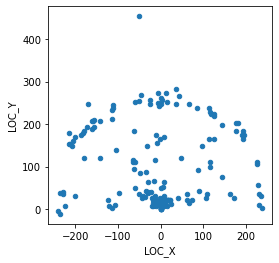

In [32]:
ax = df_shots_all.plot('LOC_X', 'LOC_Y', kind='scatter')
ax.set_aspect('equal')

## Get home and visitor team names

From original data.

In [33]:
home_team = df_shots.loc[0, 'HTM']
visitor_team = df_shots.loc[0, 'VTM']
home_team, visitor_team

('GSW', 'CLE')

### Use abbreviation mapping from above to get full name of home and visitor team

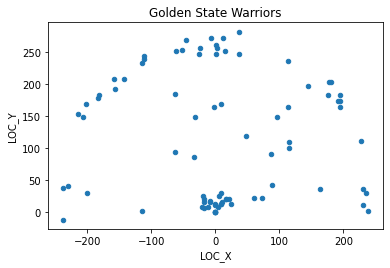

In [34]:
full_home_team = abbr_map[home_team]
full_visitor_team = abbr_map[visitor_team]
is_home = df_shots_all['TEAM_NAME'] == full_home_team
ax = df_shots_all[is_home].plot('LOC_X', 'LOC_Y', kind='scatter', title=full_home_team)
ax.set_aspect('equal')

### Transpose X and Y locations to appear as they would on TV

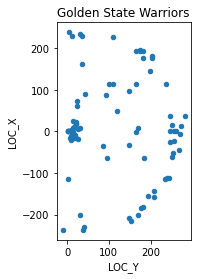

In [35]:
ax = df_shots_all[is_home].plot('LOC_Y', 'LOC_X', kind='scatter', title=full_home_team);
ax.set_aspect('equal')

## Adding the description of the event

The original play by play data had event descriptions. Let's merge them onto our DataFrame. Only one of the home and visitor description is not missing for each shooting event.

In [36]:
hd = df_pbp.set_index('EVENTNUM')['HOMEDESCRIPTION'].rename('DESCRIPTION')
vd = df_pbp.set_index('EVENTNUM')['VISITORDESCRIPTION']
desc = hd.fillna(vd)
desc.head()

EVENTNUM
0                                          None
1    Jump Ball Ezeli vs. Thompson: Tip to James
2              MISS Smith 5' Floating Jump Shot
3                   Curry REBOUND (Off:0 Def:1)
4            MISS Ezeli 7' Turnaround Hook Shot
Name: DESCRIPTION, dtype: object

In [37]:
df_shots_all2 = df_shots_all.join(desc, on='GAME_EVENT_ID')
df_shots_all2.head()

,GAME_EVENT_ID,PLAYER_NAME,PLAYER_ID,TEAM_NAME,TEAM_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_TYPE,LOC_X,LOC_Y,SHOT_MADE_FLAG,POINTS,DESCRIPTION
0,2,JR Smith,2747,Cleveland Cavaliers,1610612739,1,11,39,2PT Field Goal,-22.0,41.0,0,0,MISS Smith 5' Floating Jump Shot
1,4,Festus Ezeli,203105,Golden State Warriors,1610612744,1,11,18,2PT Field Goal,61.0,23.0,0,0,MISS Ezeli 7' Turnaround Hook Shot
2,6,Tristan Thompson,202684,Cleveland Cavaliers,1610612739,1,11,5,2PT Field Goal,17.0,23.0,1,2,Thompson 3' Layup (2 PTS) (Irving 1 AST)
3,7,Festus Ezeli,203105,Golden State Warriors,1610612744,1,10,44,2PT Field Goal,0.0,1.0,0,0,MISS Ezeli Dunk
4,9,LeBron James,2544,Cleveland Cavaliers,1610612739,1,10,37,2PT Field Goal,-7.0,11.0,1,2,James 1' Driving Layup (2 PTS) (Smith 1 AST)


# Make column for home team

In [38]:
df_shots_all2['HOME_TEAM'] = (df_shots_all2['TEAM_NAME'] == full_home_team).astype('int64')
df_shots_all2.head()

,GAME_EVENT_ID,PLAYER_NAME,PLAYER_ID,TEAM_NAME,TEAM_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_TYPE,LOC_X,LOC_Y,SHOT_MADE_FLAG,POINTS,DESCRIPTION,HOME_TEAM
0,2,JR Smith,2747,Cleveland Cavaliers,1610612739,1,11,39,2PT Field Goal,-22.0,41.0,0,0,MISS Smith 5' Floating Jump Shot,0
1,4,Festus Ezeli,203105,Golden State Warriors,1610612744,1,11,18,2PT Field Goal,61.0,23.0,0,0,MISS Ezeli 7' Turnaround Hook Shot,1
2,6,Tristan Thompson,202684,Cleveland Cavaliers,1610612739,1,11,5,2PT Field Goal,17.0,23.0,1,2,Thompson 3' Layup (2 PTS) (Irving 1 AST),0
3,7,Festus Ezeli,203105,Golden State Warriors,1610612744,1,10,44,2PT Field Goal,0.0,1.0,0,0,MISS Ezeli Dunk,1
4,9,LeBron James,2544,Cleveland Cavaliers,1610612739,1,10,37,2PT Field Goal,-7.0,11.0,1,2,James 1' Driving Layup (2 PTS) (Smith 1 AST),0


## Examining Shot Locations
Looking at the range of **LOC_X** and **LOC_Y** columns it seems apparent that the dimensions are feet multiplied by 10 since a basketball court is 94ft long by 50ft wide. 

Since, there are negative values for **LOC_X** some more investigation yields that the actual basket is located at **LOC_X** equal to 0. The actual basket is 4 feet from the edge of the court (-40 for **LOC_X**). This means the max value for **LOC_X** would be 900.

## Transforming Visitor Shot Locations
The same values for **LOC_X** and **LOC_Y** are used regardless of the team. To animate a game, we need to translate the shots of one team over to the other side of the court. For the visiting team we subtract the x-axis location from 900 to move it to the other side of the court. Note, we also transposed so that our court will be wide and not long.

In [39]:
import numpy as np
is_home = df_shots_all2['HOME_TEAM'] == 1
x = df_shots_all2['LOC_Y'] + 40
x = np.where(is_home, x, 900 - x)

df_shots_all2['LOC_X_NEW'] = x
df_shots_all2['LOC_Y_NEW'] = df_shots_all2['LOC_X']

# Build Static Visualization - Create Court

A great tutorial on creating an NBA court with shots [can be viewed here](http://savvastjortjoglou.com/nba-shot-sharts.html)

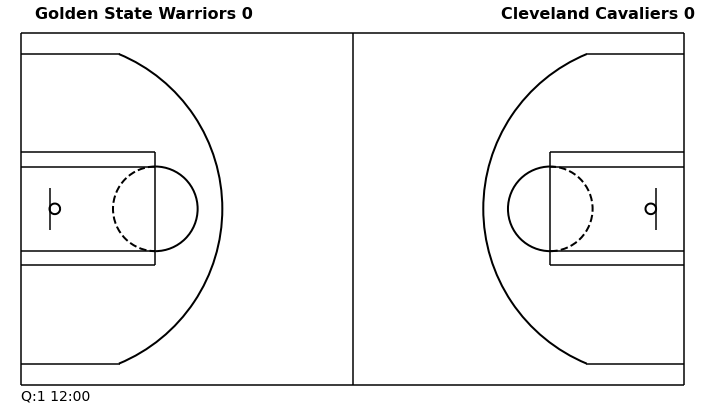

In [40]:
from matplotlib.patches import Arc, Circle

def create_court():
    # Set-up figure
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_axes([.2, .1, .6, .8], frame_on=False, xticks=[], yticks=[])
    ax.set_aspect('equal')
    
    # Draw the borders of the court
    ax.set_xlim(-20, 960)
    ax.vlines([0, 940], -250, 250)
    ax.hlines([-250, 250], 0, 940)
    ax.hlines([-80, -80, 80, 80], [0, 750] * 2, [190, 940] * 2)
    ax.hlines([-60, -60, 60, 60], [0, 750] * 2, [190, 940] * 2)
    ax.vlines([190, 750], -80, 80)
    ax.vlines(470, -250, 250)
    ax.vlines([40, 900], -30, 30)

    # Add the three point arc, free throw circle, midcourt circle and backboard and rim
    ax.add_patch(Arc((190, 0), 120, 120, theta1=-90, theta2=90, linewidth=2))
    ax.add_patch(Arc((190, 0), 120, 120, theta1=90, theta2=-90, linewidth=2, linestyle='dashed'))
    ax.add_patch(Arc((750, 0), 120, 120, theta1=90, theta2=-90, linewidth=2))
    ax.add_patch(Arc((750, 0), 120, 120, theta1=-90, theta2=90, linewidth=2, linestyle='dashed'))
    ax.hlines([-220, -220, 220, 220], [0, 800] * 2, [140, 940] * 2)
    ax.add_patch(Arc((47.5, 0), 475, 475, theta1=-67.5, theta2=67.5, linewidth=2))
    ax.add_patch(Arc((892.5, 0), 475, 475, theta1=112.5, theta2=-112.5, linewidth=2))
    ax.add_patch(Arc((47.5, 0), 15, 15, theta1=0, theta2=360, linewidth=2))
    ax.add_patch(Arc((892.5, 0), 15, 15, theta1=0, theta2=360, linewidth=2))
    ax.add_patch(Circle((470, 0), 60, facecolor='none', lw=2))
    
    # Assign to variables the plot items that will change after each iteration
    ax.text(20, 270, f"{full_home_team} 0" , 
            fontsize=16, fontweight='bold', label='home')
    ax.text(680, 270, f"{full_visitor_team} 0", 
            fontsize=16, fontweight='bold', label='visitor')
    ax.text(0, -270, "Q:1 12:00", fontsize= 14, label='time')
    ax.text(200, -270, "", fontsize=14, label='description')
    return fig, ax

fig, ax = create_court()

## Add Shot Data

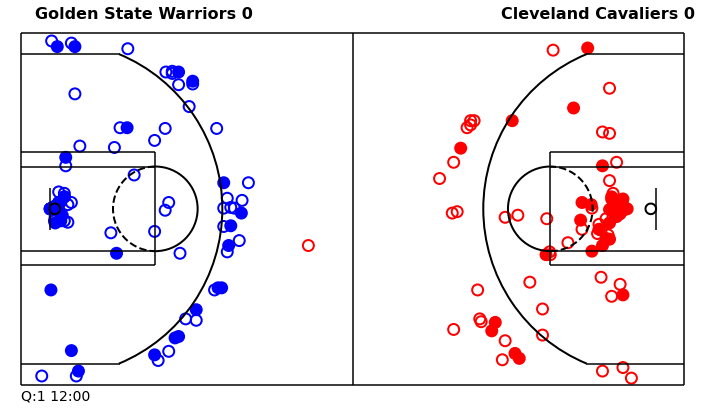

In [41]:
fig, ax = create_court()

missed = df_shots_all2['SHOT_MADE_FLAG'] == 0
edgecolor = df_shots_all2['HOME_TEAM'].replace({0: 'r', 1:'b'})
facecolor = edgecolor.copy()
facecolor[missed] = 'none' 

df_shots_all2['FACECOLOR'] = facecolor
df_shots_all2['EDGECOLOR'] = edgecolor
ax.scatter('LOC_X_NEW', 'LOC_Y_NEW', marker='o', s=120, facecolors='FACECOLOR',
           edgecolors='EDGECOLOR', lw=2, data=df_shots_all2)

# Player Images
We can add player images to our visualization after every shot they take. After clicking on individual player images, I discovered the pattern for finding the correct player image for the correct year. You need to have the team ID, year, and player ID.

In [42]:
unique_players = df_shots_all2[['TEAM_ID', 'PLAYER_ID']].drop_duplicates()
unique_players.head()

,TEAM_ID,PLAYER_ID
0,1610612739,2747
1,1610612744,203105
2,1610612739,202684
4,1610612739,2544
5,1610612744,201939


### Loop through each unique player for each team 
We use the `imread` Matplotlib function to convert an image into a numpy array of RGBA values which is stored in a dictionary.

In [43]:
base_image_url = "https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/"
year = 2016
player_image_data = {}
for _, row in unique_players.iterrows():
    team_id = row['TEAM_ID']
    player_id = row['PLAYER_ID']
    end_image_url = f"{team_id}/{year}/260x190/{player_id}.png"
    try:
        image_array = plt.imread(base_image_url + end_image_url)
    except:
        end_image_url = f"{team_id}/{year - 1}/260x190/{player_id}.png"
        image_array = plt.imread(base_image_url + end_image_url)
    if team_id not in player_image_data:
        player_image_data[team_id] = {player_id: image_array}
    else:
        player_image_data[team_id][player_id] = image_array

## Player images on court

We add a new Axes for to hold the player images for each team. Below, we test out the location of

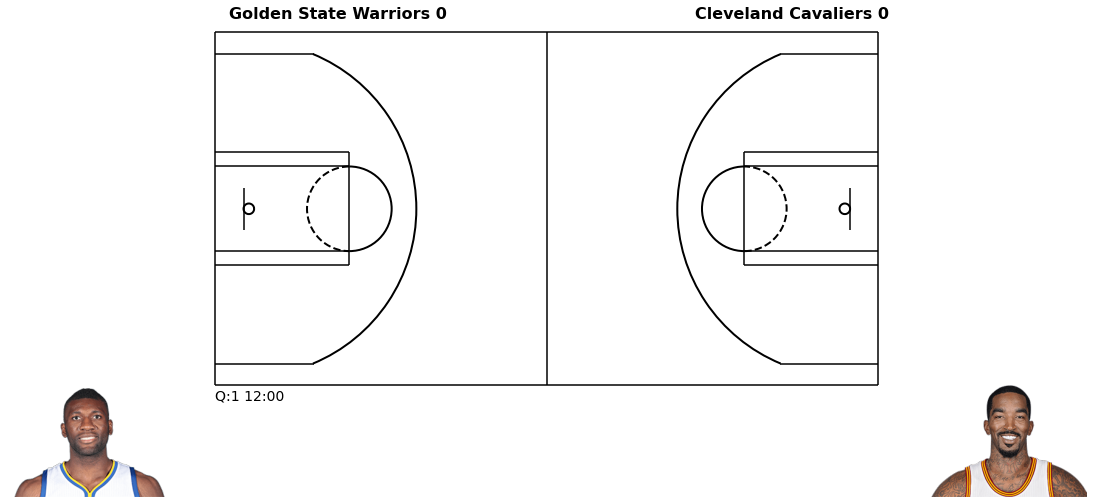

In [44]:
fig, ax = create_court()
ax_image_left = fig.add_axes((0, 0, .2, .2), zorder=-1, 
                             frame_on=False, xticks=[], yticks=[])
ax_image_right = fig.add_axes((.8, 0, .2, .2), zorder=-1, 
                              frame_on=False, xticks=[], yticks=[])

im_left = ax_image_left.imshow(player_image_data[1610612744][203105])
im_right = ax_image_right.imshow(player_image_data[1610612739][2747])

## Animation

The **FuncAnimation** function must be imported which utilizes a user-defined function to control the objects in the plot.

In [45]:
from matplotlib.animation import FuncAnimation

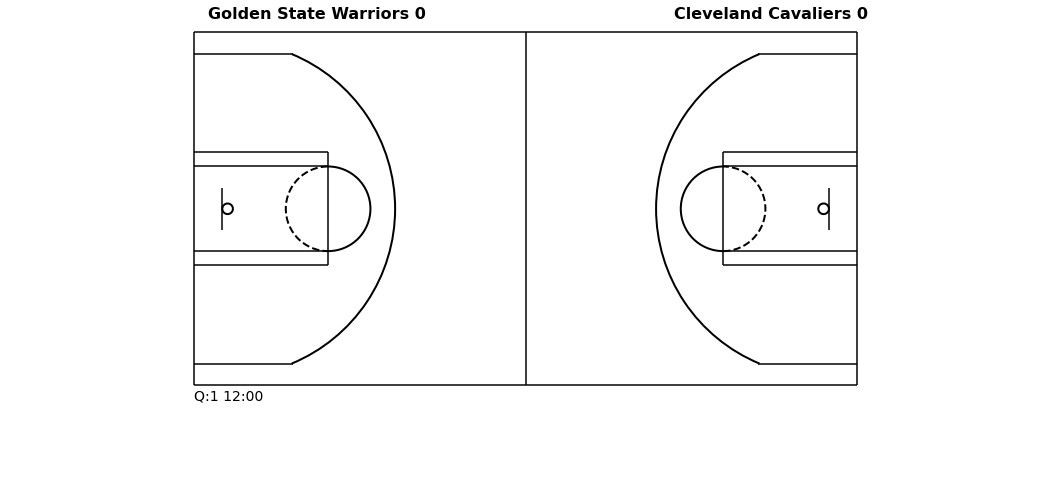

In [46]:
# Recreate the court
fig, ax = create_court()
ax_image_left = fig.add_axes((0, 0, .2, .2), zorder=-1, 
                             frame_on=False, xticks=[], yticks=[])
ax_image_right = fig.add_axes((.8, 0, .2, .2), zorder=-1, 
                              frame_on=False, xticks=[], yticks=[])
im_left = ax_image_left.imshow([[0]])
im_right = ax_image_right.imshow([[0]])
im_left.set_data([[]])
im_right.set_data([[]])

scores = {'visitor': 0, 'home': 0} 
texts = {t.get_label(): t for t in ax.texts}

def init():
    scores['home'] = 0
    scores['visitor'] = 0
    texts['home'].set_text(f"{full_home_team} {scores['home']}")
    texts['visitor'].set_text(f"{full_visitor_team} {scores['visitor']}")
    texts['time'].set_text("Q:1 12:00")               
    texts['description'].set_text("")
    im_left.set_data([[]])
    im_right.set_data([[]])
                              
# The update function is called as frequently as the interval parameter below (in milliseconds).
def update(frame_number):
    # Change the score
    if frame_number == 0:
        return
                              
    im_left.set_data([[]])
    im_right.set_data([[]])

    current_row = df_shots_all2.iloc[frame_number - 1]
    ax.scatter('LOC_X_NEW', 'LOC_Y_NEW', marker='o', s=120,
                      facecolors='FACECOLOR', edgecolors='EDGECOLOR', 
                      lw=2, data=current_row);

    team_type = 'home' if current_row['HOME_TEAM'] == 1 else 'visitor'
    scores[team_type] += current_row['POINTS']
    texts['home'].set_text(f"{full_home_team} {scores['home']}")
    texts['visitor'].set_text(f"{full_visitor_team} {scores['visitor']}")
    
    per = current_row['PERIOD']
    mr = current_row['MINUTES_REMAINING']
    sr = current_row['SECONDS_REMAINING']
    texts['time'].set_text(f"Q:{per} {mr:02d}:{sr:02d}")               
    texts['description'].set_text(current_row['DESCRIPTION'])
                              
    team_id = current_row['TEAM_ID']
    player_id = current_row['PLAYER_ID']
    image_array = player_image_data[team_id][player_id]

    if team_type == 'home':
        im_left.set_data(image_array)
    else:
        im_right.set_data(image_array)

animation = FuncAnimation(fig, func=update, frames=len(df_shots_all2) + 1, 
                          init_func=init, interval=10, repeat=False)

In [47]:
from matplotlib.animation import writers
writers.list()

['pillow', 'ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']

In [48]:
animation.save('videos/nba_game_animation.mp4', fps=1.5)

## Embed into Jupyter Notebook

In [49]:
from IPython.display import Video
Video('videos/nba_game_animation.mp4', width=800)